In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torchdiffeq import odeint
from torch.nn.parameter import Parameter
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.normal import Normal

import gpytorch

from reggae.data_loaders import load_barenco_puma, DataHolder

from matplotlib import pyplot as plt

import numpy as np

f64 = np.float64

torch.Size([3, 5, 7])
tensor([[0.0000],
        [0.1667],
        [0.3333],
        [0.5000],
        [0.6667],
        [0.8333],
        [1.0000]], dtype=torch.float64)


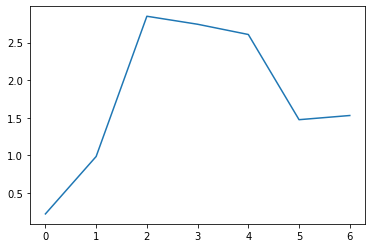

In [2]:
m_observed, f_observed, σ2_m_pre, σ2_f_pre, t = load_barenco_puma('../data/')

m_df, m_observed = m_observed
f_df, f_observed = f_observed
# Shape of m_observed = (replicates, genes, times)
m_observed = torch.tensor(m_observed)
f_observed = torch.tensor(f_observed)
data = (m_observed, f_observed)

σ2_m_pre = f64(σ2_m_pre)
σ2_f_pre = f64(σ2_f_pre)
noise_data = (σ2_m_pre, σ2_f_pre)

print(m_observed.shape)

num_genes = m_observed.shape[1]
num_tfs = f_observed.shape[1]
N_m = m_observed.shape[2]
granularity = 100
t_start = f64(0)
t_end = f64(1)
t = torch.linspace(t_start, t_end, granularity, dtype=torch.float64).view((-1, 1))
t_inducing = torch.linspace(t_start, t_end, 7, dtype=torch.float64).reshape((-1, 1))
print(t_inducing)
plt.plot(m_observed[0,0])

In [3]:
def positivity_transform(value):
    return torch.log(1+torch.exp(value))

def plot_genes():
    initial_value = torch.zeros((num_genes, 1), dtype=torch.float64) #, dtype=torch.float64
    outputs = torch.squeeze(model(t.view(-1), initial_value))
    print(outputs.shape)
    plt.figure(figsize=(5, 8))
    for i in range(num_genes):
        plt.subplot(511+i)
        plt.plot(t, torch.squeeze(outputs[0]).detach())
        plt.scatter(t_inducing, m_observed[0][i])

In [62]:
class GP(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, num_tfs):
        likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=num_tfs)
        super(GP, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean(batch_shape=torch.Size([num_tfs]))
        rbf = gpytorch.kernels.RBFKernel(eps=0.15, batch_shape=torch.Size([num_tfs])) # eps is min lengthscale
        rbf.lengthscale = f64(0.2)
        self.covar_module = gpytorch.kernels.ScaleKernel(rbf, batch_shape=torch.Size([num_tfs]))


    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal.from_batch_mvn(
            gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
        )


class ODEModel(nn.Module):
    """
    Description blah
    Parameters
    ----------
    num_genes : int
    Number of genes.
    num_tfs : int

    t_inducing : int
    inducing timepoints.
    """
    def __init__(self, num_genes, num_tfs, t_inducing):
        super(ODEModel, self).__init__()
        self.num_genes = num_genes
        self.num_tfs = num_tfs
        self.num_inducing = 7
        self.inducing_inputs = t_inducing

        self.decay_rate = Parameter(1*torch.ones((self.num_genes, 1), dtype=torch.float64))
        self.basal_rate = Parameter(0.2*torch.ones((self.num_genes, 1), dtype=torch.float64))
        self.sensitivity = Parameter(2*torch.ones((self.num_genes, 1), dtype=torch.float64))
        self.w = Parameter(torch.ones((self.num_genes, self.num_tfs), dtype=torch.float64))
        self.w_0 = Parameter(torch.ones((self.num_tfs), dtype=torch.float64))
        variat_mean = torch.rand((self.num_tfs, self.num_inducing, 1), dtype=torch.float64) * 10 - 5
        print(variat_mean)
        variat_var = torch.eye(self.num_inducing, dtype=torch.float64).view(1, self.num_inducing, self.num_inducing)
        variat_var = variat_var.repeat(self.num_tfs, 1, 1)
        self.variat_mean = Parameter(variat_mean)
        self.variat_var = Parameter(variat_var)

        self.inducing_targets = torch.randn(self.num_tfs, self.num_inducing, dtype=torch.float64) #This is not used
        # self.gp = GP(self.inducing_inputs.view(-1), self.inducing_targets, self.num_tfs)
        self.nfe = 0
        self.l2 = Parameter(0.2*torch.ones((num_tfs), dtype=torch.float64))
        self.v = Parameter(1 * torch.ones((num_tfs), dtype=torch.float64))

    def rbf(self, x: torch.Tensor, x2: torch.Tensor=None):
        """
        Radial basis function kernel.
        @param x:
        @param x2: if None, then x2 becomes x
        @return: K of shape (I, |x|, |x2|)
        """
        if x2==None:
            x2 = x
        x = x.view(-1)
        x2 = x2.view(-1)
        sq_dist = torch.square(x.view(-1, 1)-x2)
        sq_dist = sq_dist.repeat(self.num_tfs, 1, 1)
        sq_dist = torch.div(sq_dist, 2*self.l2.view((-1, 1, 1)))

        K =  self.v.view(-1, 1, 1) * torch.exp(-sq_dist)
        return K


    def forward(self, t, h):
        """
        t : torch.Tensor
            Shape (num_times)
        h : torch.Tensor the initial state of the ODE
            Shape (num_genes, 1)
        Returns
        -------
        Returns evolved h across times t.
        Shape (num_genes, num_points).
        """
        self.nfe = 0
        num_times = t.size()

        # 1: Likelihood step: Sample from variational distribution
        self.Kmm = self.rbf(self.inducing_inputs)
        self.inv_Kmm = torch.inverse(self.Kmm)


        # Integrate forward from the batch of initial positions z.
        h = odeint(self.odefunc, h, t, method='dopri5', rtol=1e-3, atol=1e-5) # shape (num_genes, num_times, 1

        # 2: KL terms:
        q = MultivariateNormal(self.variat_mean, self.variat_var)
        μ = torch.zeros((self.num_tfs, self.num_inducing), dtype=torch.float64)
        p = MultivariateNormal(μ, self.Kmm)
        kl = torch.distributions.kl.kl_divergence(p, q)
        print(kl.shape)
        return torch.transpose(h, 0, 1), kl


    def odefunc(self, t, h):
        self.nfe += 1
        # print(t)
        # h is of shape (num_genes, 1)
        decay = torch.multiply(self.decay_rate.view(-1), h.view(-1)).view(-1, 1)

        p = self.get_tfs(t)
        Gp = self.G(p)
        # print(Gp.shape)
        # print(self.basal_rate, Gp, decay)

        return self.basal_rate + self.sensitivity * Gp - decay

    def get_tfs(self, t):
        Ksm = self.rbf(t, self.inducing_inputs) # (I, T*, T)
        α = Ksm.matmul(self.inv_Kmm) # (I, T*, T)
        m_s = torch.matmul(α, self.variat_mean) # (I, T*, T*)
        Kss = self.rbf(t) # (I, T*, T*)
        S_Kmm = self.variat_var - self.Kmm # (I, T, T)
        AS_KA = torch.matmul(torch.matmul(α, S_Kmm), torch.transpose(α, 1, 2)) # (I, T*, T*)
        S_s = (Kss + AS_KA) # (I, T*, T*)
        q_f = Normal(torch.squeeze(m_s), torch.squeeze(S_s))
        f = q_f.sample() # TODO: multiple samples
        return f
    # def get_tfs(self, at):
    #     self.gp.set_train_data(self.inducing_sources, self.inducing_targets)
    #     f_mvn = self.gp(self.inducing_sources) #
    #
    #     self.gp.eval() # activate posterior mode (calls to gp() will be posterior predictive)
    #
    #     # print(at.shape, self.inducing_targets.shape)
    #     inputs = torch.cat([self.inducing_targets, at.view(-1)])
    #     # f_mvn = self.gp(at.view(-1))
    #     f_mvn = self.gp(inputs)
    #     # print(f_mvn.mean.shape)
    #
    #     self.gp.train()
    #
    #     return torch.unsqueeze(f_mvn.mean[-1], 0) #TODO support multi tfs, in which case the 0 dim is num_tfs

    def G(self, p):
        # p_pos = positivity_transform(p)
        # interactions = torch.matmul(self.w, torch.log(p_pos+1e-50)) + self.w_0 #(TODO)
        # return torch.sigmoid(interactions) # TF Activation Function (sigmoid)
        return p

    # def latent(self, t):
    #     self.gp.eval()
    #     f_mvn = self.gp(t)
    #     return positivity_transform(f_mvn.mean)

    def train(self, mode=True):
        # self.gp.train(mode)
        # self.gp.likelihood.train(mode)
        super().train(mode)

In [63]:
def train(optimizer, loss_fn, epochs=10):
    basalrates = list()
    decayrates = list()
    lengthscales = list()
    plt.figure()
    plt.plot(t_inducing, m_observed[0,0], label='real')

    for epoch in range(epochs):
        optimizer.zero_grad()
        # Output from model
        initial_value = torch.zeros((num_genes, 1), dtype=torch.float64) #, dtype=torch.float64
        output, kl = torch.squeeze(model(t_inducing.view(-1), initial_value))
        print('success', kl)

        # Calc loss and backprop gradients
        loss = loss_fn(output, m_observed[0])

        loss.backward()
        print('Epoch %d/%d - Loss: %.3f %.3f b: %.2f d %.2f λ: %.7f' % (
            epoch + 1, epochs, loss.item(),
            output[3,3].item(),
            model.basal_rate[0].item(),
            model.decay_rate[0].item(),
            model.l2.squeeze().item()
        ))
        optimizer.step()

        basalrates.append(model.basal_rate.detach().numpy())
        decayrates.append(model.decay_rate.detach().numpy())
        lengthscales.append(model.l2.squeeze().item())
        if (epoch % 10) ==0:
            plt.plot(t_inducing, output[0].detach().numpy(), label='epoch'+str(epoch))

    plt.legend()
    return output, (basalrates, decayrates, lengthscales)

In [64]:
model = ODEModel(num_genes, num_tfs, t_inducing)
optimizer = torch.optim.Adam(model.parameters(), lr=0.08)  # Includes GaussianLikelihood parameters
loss_fn = torch.nn.MSELoss(reduction='mean')

model.rbf(model.inducing_inputs)
list(model.parameters())

tensor([[[-1.9141],
         [-4.7774],
         [ 3.2341],
         [ 1.2621],
         [-1.2087],
         [ 4.0223],
         [ 4.1059]]], dtype=torch.float64)


[Parameter containing:
 tensor([[1.],
         [1.],
         [1.],
         [1.],
         [1.]], dtype=torch.float64, requires_grad=True),
 Parameter containing:
 tensor([[0.2000],
         [0.2000],
         [0.2000],
         [0.2000],
         [0.2000]], dtype=torch.float64, requires_grad=True),
 Parameter containing:
 tensor([[2.],
         [2.],
         [2.],
         [2.],
         [2.]], dtype=torch.float64, requires_grad=True),
 Parameter containing:
 tensor([[1.],
         [1.],
         [1.],
         [1.],
         [1.]], dtype=torch.float64, requires_grad=True),
 Parameter containing:
 tensor([1.], dtype=torch.float64, requires_grad=True),
 Parameter containing:
 tensor([[[-1.9141],
          [-4.7774],
          [ 3.2341],
          [ 1.2621],
          [-1.2087],
          [ 4.0223],
          [ 4.1059]]], dtype=torch.float64, requires_grad=True),
 Parameter containing:
 tensor([[[1., 0., 0., 0., 0., 0., 0.],
          [0., 1., 0., 0., 0., 0., 0.],
          [0., 0., 1

### Outputs prior to training:

In [65]:
plot_genes()

NotImplementedError: 

success
Epoch 1/10 - Loss: 4.415 -0.871 b: 0.98 d 1.75 λ: 0.2000000
success
Epoch 2/10 - Loss: 4.262 -0.851 b: 1.06 d 1.82 λ: 0.2000000
success
Epoch 3/10 - Loss: 4.112 -0.809 b: 1.13 d 1.89 λ: 0.2000000
success
Epoch 4/10 - Loss: 3.791 -0.756 b: 1.20 d 1.95 λ: 0.2000000
success
Epoch 5/10 - Loss: 3.573 -0.626 b: 1.28 d 2.01 λ: 0.2000000
success
Epoch 6/10 - Loss: 3.464 -0.652 b: 1.35 d 2.07 λ: 0.2000000
success
Epoch 7/10 - Loss: 3.248 -0.558 b: 1.42 d 2.13 λ: 0.2000000
success
Epoch 8/10 - Loss: 3.017 -0.439 b: 1.50 d 2.18 λ: 0.2000000
success
Epoch 9/10 - Loss: 3.011 -0.494 b: 1.57 d 2.23 λ: 0.2000000
success
Epoch 10/10 - Loss: 2.752 -0.372 b: 1.63 d 2.27 λ: 0.2000000


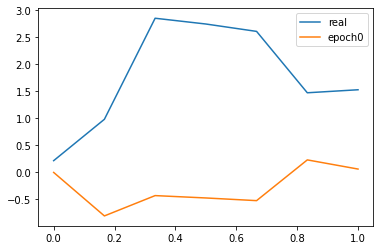

In [61]:
output, params = train(optimizer, loss_fn, 10)

In [77]:
print(model.gp.covar_module.base_kernel.lengthscale)

tensor([[0.8441]], grad_fn=<SoftplusBackward>)


In [175]:
plt.figure()
print(t.dtype)
print(model.latent(t).shape)
plt.plot(t, model.latent(t).detach())
plt.scatter(t_inducing, model.inducing_targets.detach(), marker='x')
plt.title('Latent')

torch.float64


RuntimeError: expected scalar type Double but found Float

<Figure size 432x288 with 0 Axes>

torch.Size([5, 100])


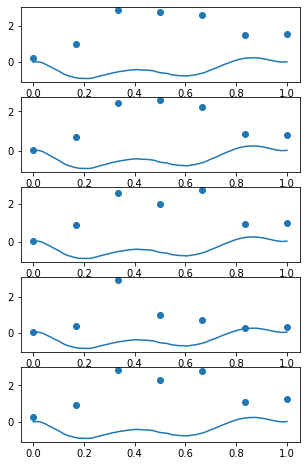

In [59]:
plot_genes()

torch.Size([100, 1])


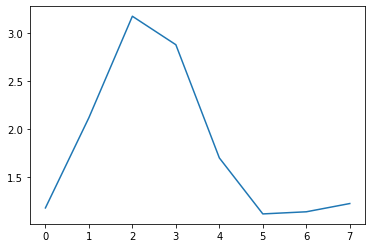

In [32]:
print(t.shape)

t_ = torch.cat([t_inducing, torch.tensor([0.01], dtype=torch.float64).view(-1,1)])
model.gp.eval()
plt.plot(model.gp(t_).mean.detach())

In [ ]:
plt.figure(figsize=(5, 6))
basal, decay, lengthscale = params
basals = np.array(basal)
decays = np.array(decay)
lengthscales = np.array(lengthscale)
print(lengthscales.shape)
plt.subplot(311)
# print(basals[:,0])
plt.plot(basals[:,0])
# plt.ylim(1, 1.5)
plt.subplot(312)
plt.plot(decays[:,0])
# plt.ylim(0.5, 1)
plt.subplot(313)
plt.plot(lengthscales)
# plt.ylim(1, 1.2)

print(model.basal_rate)


In [96]:
model.w

Parameter containing:
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.]], dtype=torch.float64, requires_grad=True)

In [89]:
model.sensitivity
# model.gp.covar_module.outputscale

Parameter containing:
tensor([[8.9318],
        [9.4879],
        [9.1635],
        [5.7552],
        [9.1064]], dtype=torch.float64, requires_grad=True)